In [1]:
import torch
import pandas as pd
import numpy as np

from ltn_imp.automation.knowledge_base import KnowledgeBase
from ltn_imp.automation.data_loaders import LoaderWrapper

## Data Preparation

In [2]:
!poetry run poe download-datasets

Poe => mkdir -p examples/datasets
Poe => curl -L -o examples/datasets/iris_training.csv https://raw.githubusercontent.com/tommasocarraro/LTNtorch/main/examples/datasets/iris_training.csv
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2218  100  2218    0     0  29688      0 --:--:-- --:--:-- --:--:-- 29972
Poe => curl -L -o examples/datasets/iris_test.csv https://raw.githubusercontent.com/tommasocarraro/LTNtorch/main/examples/datasets/iris_test.csv
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   598  100   598    0     0   8143      0 --:--:-- --:--:-- --:--:--  8191
Poe => curl -L -o examples/datasets/real_estate.csv https://raw.githubusercontent.com/tommasocarraro/LTNtorch/main/examples/datasets/real-estate.csv
  % Total    % Received % Xferd  Average Spee

In [3]:
train_data = pd.read_csv("datasets/iris_training.csv")
test_data = pd.read_csv("datasets/iris_test.csv")

train_labels = train_data.pop("species")
test_labels = test_data.pop("species")

train_data = torch.tensor(train_data.to_numpy()).float()
test_data = torch.tensor(test_data.to_numpy()).float()

train_labels = torch.tensor(train_labels.to_numpy()).float()
test_labels = torch.tensor(test_labels.to_numpy()).float()

In [4]:
class DataLoader(object):
    def __init__(self,
                 data,
                 labels,
                 batch_size=1,
                 shuffle=True):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __len__(self):
        return int(np.ceil(self.data.shape[0] / self.batch_size))

    def __iter__(self):
        n = self.data.shape[0]
        idxlist = list(range(n))
        if self.shuffle:
            np.random.shuffle(idxlist)

        for _, start_idx in enumerate(range(0, n, self.batch_size)):
            end_idx = min(start_idx + self.batch_size, n)
            data = self.data[idxlist[start_idx:end_idx]]
            labels = self.labels[idxlist[start_idx:end_idx]]

            yield data, labels

# create train and test loader
train_loader = DataLoader(train_data, train_labels, 64, shuffle=True)
test_loader = DataLoader(test_data, test_labels, 64, shuffle=False)

In [5]:
def compute_accuracy(loader, model, num_classes):
    class_correct = np.zeros(num_classes)
    class_total = np.zeros(num_classes)

    for data, labels in loader:
        predictions = model(data).detach().numpy()
        predictions = np.argmax(predictions, axis=1)
        labels = labels.numpy()  # Convert labels to numpy array

        for i in range(num_classes):
            class_mask = (labels == i)
            class_correct[i] += np.sum(predictions[class_mask] == labels[class_mask])
            class_total[i] += np.sum(class_mask)

    class_accuracy = class_correct / class_total

    # Print accuracy for each class
    for i in range(num_classes):
        print(f'Accuracy for class {i}: {class_accuracy[i]:.2f}')

    # Compute and print general accuracy
    overall_accuracy = np.sum(class_correct) / np.sum(class_total)
    print(f'Overall accuracy: {overall_accuracy:.2f}')

In [6]:
loaders = [LoaderWrapper(loader=train_loader, variables=["flower"], targets=["y"])]
kb = KnowledgeBase("multi_config.yaml", loaders=loaders)
kb.predicates
kb.constant_mapping

(self, flower, c)
['flower', 'c']


{'setosa': tensor([0.]),
 'versicolor': tensor([1.]),
 'virginica': tensor([2.]),
 'zero': tensor([1., 0., 0.]),
 'one': tensor([0., 1., 0.]),
 'two': tensor([0., 0., 1.])}

In [7]:
mlp = kb.predicates["Iris"]
classifier =  kb.predicates["Classifier"]

## My Implementation

In [8]:
compute_accuracy(train_loader, model = mlp, num_classes=3)

Accuracy for class 0: 0.81
Accuracy for class 1: 0.28
Accuracy for class 2: 0.00
Overall accuracy: 0.37


In [9]:
compute_accuracy(test_loader, model = mlp,num_classes=3)

Accuracy for class 0: 0.75
Accuracy for class 1: 0.21
Accuracy for class 2: 0.00
Overall accuracy: 0.30


In [10]:
kb.optimize(num_epochs=801, log_steps=200)

{'setosa': tensor([0.]), 'versicolor': tensor([1.]), 'virginica': tensor([2.]), 'zero': tensor([1., 0., 0.]), 'one': tensor([0., 1., 0.]), 'two': tensor([0., 0., 1.]), 'flower': tensor([[5.6000, 2.5000, 3.9000, 1.1000],
        [4.9000, 2.5000, 4.5000, 1.7000],
        [6.2000, 2.8000, 4.8000, 1.8000],
        [7.7000, 3.8000, 6.7000, 2.2000],
        [6.3000, 2.7000, 4.9000, 1.8000],
        [6.5000, 2.8000, 4.6000, 1.5000],
        [6.9000, 3.2000, 5.7000, 2.3000],
        [7.4000, 2.8000, 6.1000, 1.9000],
        [4.9000, 2.4000, 3.3000, 1.0000],
        [6.9000, 3.1000, 4.9000, 1.5000],
        [5.0000, 3.4000, 1.6000, 0.4000],
        [7.6000, 3.0000, 6.6000, 2.1000],
        [5.4000, 3.4000, 1.5000, 0.4000],
        [5.8000, 2.6000, 4.0000, 1.2000],
        [4.8000, 3.4000, 1.6000, 0.2000],
        [5.8000, 2.7000, 5.1000, 1.9000],
        [4.7000, 3.2000, 1.3000, 0.2000],
        [6.4000, 2.8000, 5.6000, 2.2000],
        [5.0000, 2.3000, 3.3000, 1.0000],
        [4.7000, 3.2000,

KeyError: 'Variable prob not recognized'

In [ ]:
compute_accuracy(train_loader, model = mlp, num_classes=3)

Accuracy for class 0: 1.00
Accuracy for class 1: 0.94
Accuracy for class 2: 1.00
Overall accuracy: 0.98


In [ ]:
compute_accuracy(test_loader,model = mlp, num_classes=3)

Accuracy for class 0: 1.00
Accuracy for class 1: 0.93
Accuracy for class 2: 1.00
Overall accuracy: 0.97


## Computation Graph 

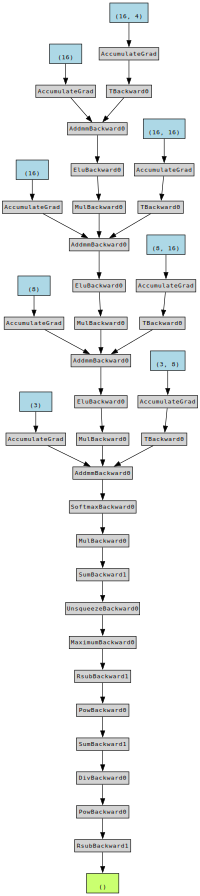

In [ ]:
batch = next(iter(test_loader))

var_mapping = {}

kb.partition_data(var_mapping,batch, loaders[0] )

kb.rules[0].comp_graph(var_mapping)